# ARIMA Time Series Forecasting

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## EDA and Preprocessing

In [61]:
# Load the data
Canadian_data=pd.read_csv('Canadian Car Sales.csv')

# Display the shape of the data
Canadian_data.shape

(6582, 18)

In [62]:
Canadian_data.head()

,REF_DATE,GEO,DGUID,Vehicle type,Origin of manufacture,Sales,Seasonal adjustment,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1953-01,Canada,2016A000011124,Passenger cars,North America,Units,Unadjusted,Units,300,units,0,v42169923,1.2.2.1.1,21742.0,NaN,NaN,NaN,0
1,1953-02,Canada,2016A000011124,Passenger cars,North America,Units,Unadjusted,Units,300,units,0,v42169923,1.2.2.1.1,28711.0,NaN,NaN,NaN,0
2,1953-03,Canada,2016A000011124,Passenger cars,North America,Units,Unadjusted,Units,300,units,0,v42169923,1.2.2.1.1,36867.0,NaN,NaN,NaN,0
3,1953-04,Canada,2016A000011124,Passenger cars,North America,Units,Unadjusted,Units,300,units,0,v42169923,1.2.2.1.1,39903.0,NaN,NaN,NaN,0
4,1953-05,Canada,2016A000011124,Passenger cars,North America,Units,Unadjusted,Units,300,units,0,v42169923,1.2.2.1.1,37717.0,NaN,NaN,NaN,0


In [63]:
# Updating the header
Canadian_data.columns


Index(['REF_DATE', 'GEO', 'DGUID', 'Vehicle type', 'Origin of manufacture',
       'Sales', 'Seasonal adjustment', 'UOM', 'UOM_ID', 'SCALAR_FACTOR',
       'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS', 'SYMBOL',
       'TERMINATED', 'DECIMALS'],
      dtype='object')

In [77]:
df = Canadian_data[['REF_DATE', 'VALUE']]
df['REF_DATE']=pd.to_datetime(df['REF_DATE'])
df.set_index('REF_DATE', inplace=True)

/var/folders/tr/psvn_y8x0w34ssccnb237zq00000gn/T/ipykernel_19327/866418036.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['REF_DATE']=pd.to_datetime(df['REF_DATE'])


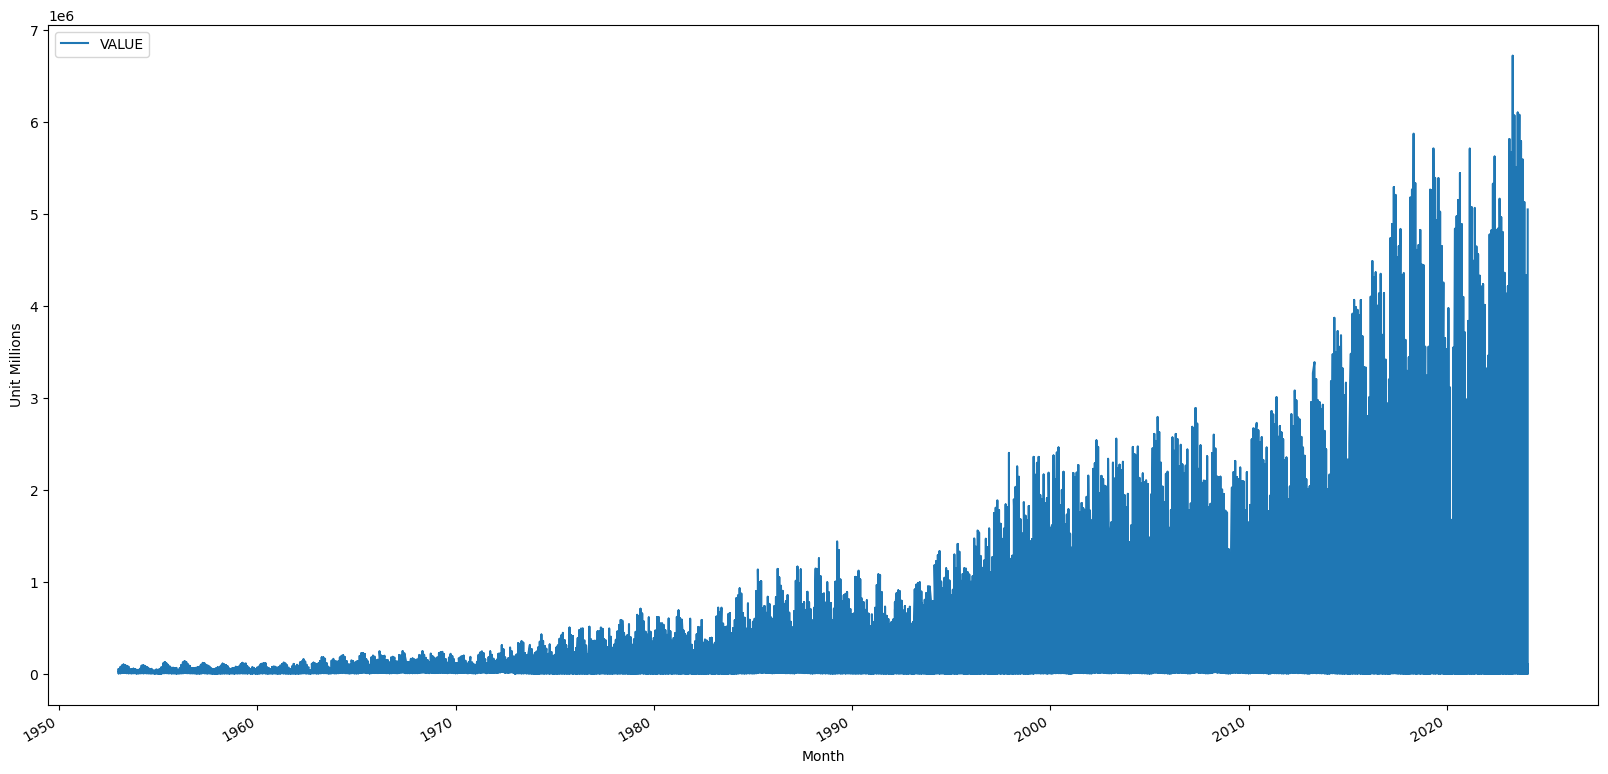

In [75]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
df.plot()
plt.xlabel('Month')
plt.ylabel('Unit Millions')
plt.show()


# Testing for Stationarity

In [78]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['VALUE'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: 7.998040
p-value: 1.000000


In [81]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['VALUE'])

ADF Test Statistic : 7.998039673529282
p-value : 1.0
#Lags Used : 35
Number of Observations : 6546
weak evidence against null hypothesis,indicating it is non-stationary 


In [82]:
df['Sales First Difference'] = df['VALUE'] - df['VALUE'].shift(1)
df['Seasonal First Difference']=df['VALUE']- df['VALUE'].shift(12)
df.head()

/var/folders/tr/psvn_y8x0w34ssccnb237zq00000gn/T/ipykernel_19327/272879775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sales First Difference'] = df['VALUE'] - df['VALUE'].shift(1)
/var/folders/tr/psvn_y8x0w34ssccnb237zq00000gn/T/ipykernel_19327/272879775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Seasonal First Difference']=df['VALUE']- df['VALUE'].shift(12)


,VALUE,Sales First Difference,Seasonal First Difference
REF_DATE,,,
1953-01-01,21742.0,NaN,NaN
1953-02-01,28711.0,6969.0,NaN
1953-03-01,36867.0,8156.0,NaN
1953-04-01,39903.0,3036.0,NaN
1953-05-01,37717.0,-2186.0,NaN


In [83]:
# Again testing if data is stationary
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -12.387575199278704
p-value : 4.8703080717044984e-23
#Lags Used : 35
Number of Observations : 6534
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<Axes: xlabel='REF_DATE'>

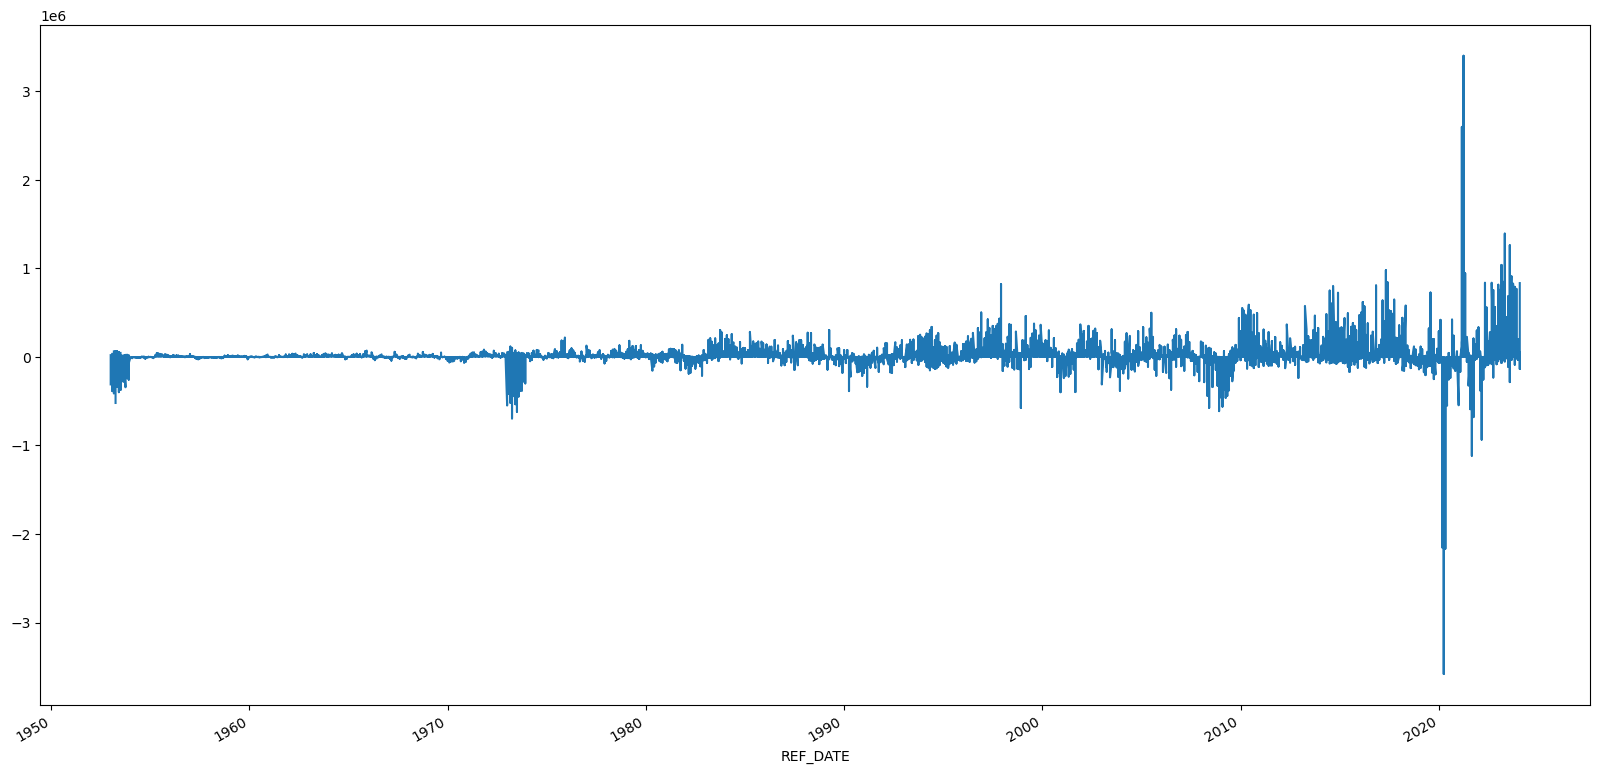

In [84]:
df['Seasonal First Difference'].plot()

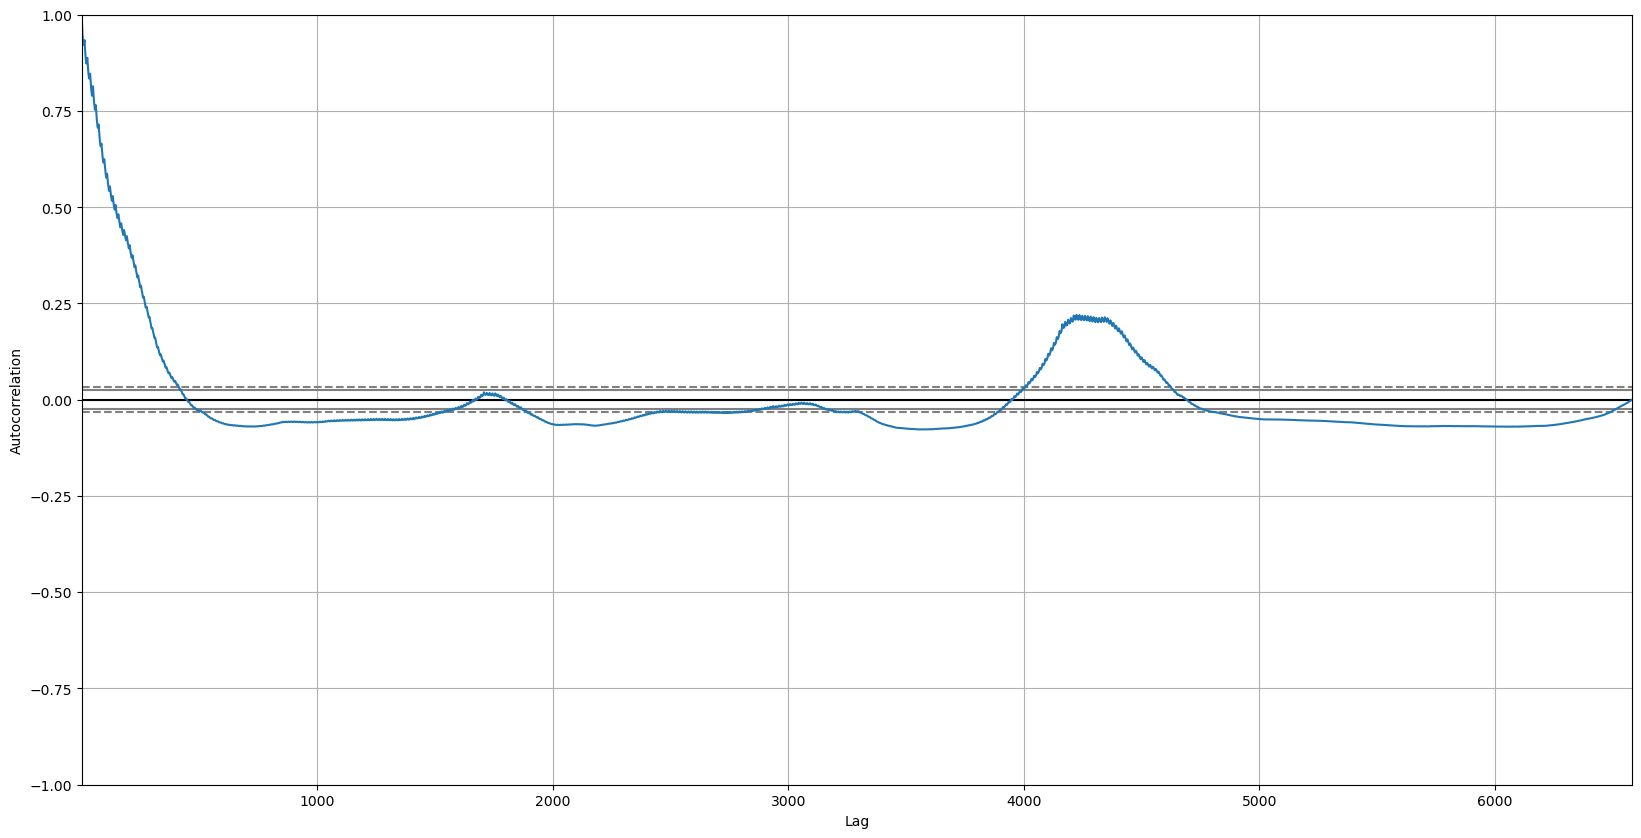

In [85]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['VALUE'])
plt.show()

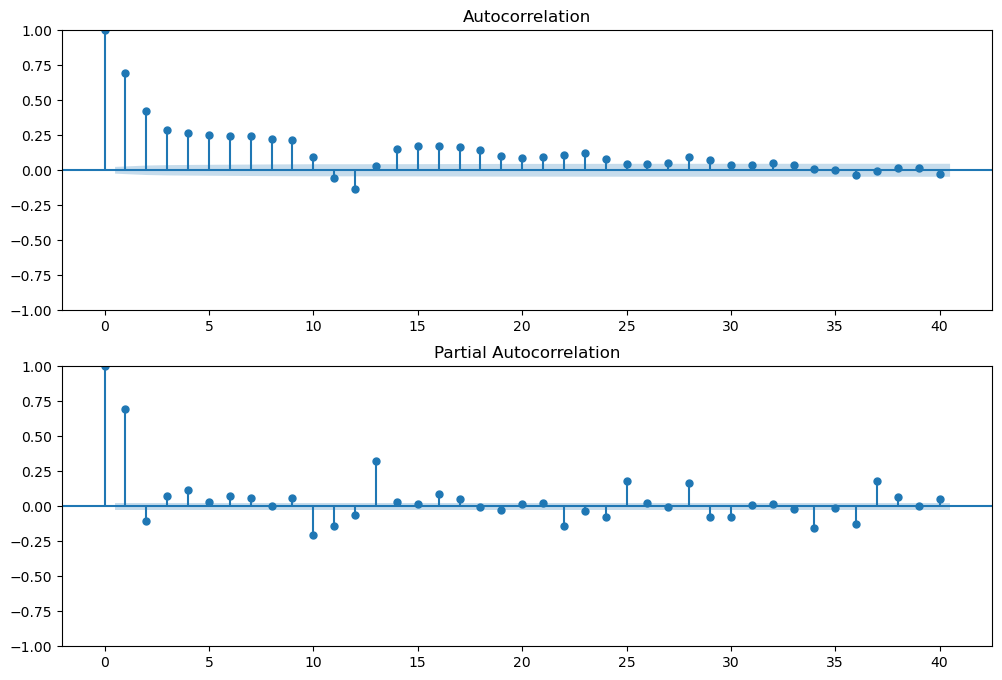

In [86]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

In [92]:
# For non-seasonal data
# p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['VALUE'], order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  VALUE   No. Observations:                 6582
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -86145.274
Date:                Fri, 19 Apr 2024   AIC                         172296.547
Time:                        15:43:08   BIC                         172316.923
Sample:                             0   HQIC                        172303.590
                               - 6582                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6148      0.013    -48.093      0.000      -0.640      -0.590
ma.L1          0.7225      0.012     62.276      0.000       0.700       0.745
sigma2      1.396e+10   1.91e-12    7.3e+21      0.000     1.4e+10     1.4e+10
===================================================================================
Ljung-Box (L1) (Q):                  22.11   Jarque-Bera (JB):           1190318.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.28   Skew:                             3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.91e+35. Standard errors may be unstable.
"""

In [101]:
df['forecast']=model_fit.predict(start=5000,end=6581,dynamic=True)
df[['VALUE','forecast']].plot(figsize=(30,8))

ValueError: cannot reindex on an axis with duplicate labels

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27588D+01    |proj g|=  9.46527D-02

At iterate    5    f=  1.27058D+01    |proj g|=  5.20435D-02

At iterate   10    f=  1.26776D+01    |proj g|=  1.51578D-02

At iterate   15    f=  1.26767D+01    |proj g|=  2.01380D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.102D-05   1.268D+01
  F =   12.676744798160293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/var/folders/tr/psvn_y8x0w34ssccnb237zq00000gn/T/ipykernel_19327/2009747523.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['forecast']=results.predict(start=90,end=103,dynamic=True)


<Axes: xlabel='REF_DATE'>

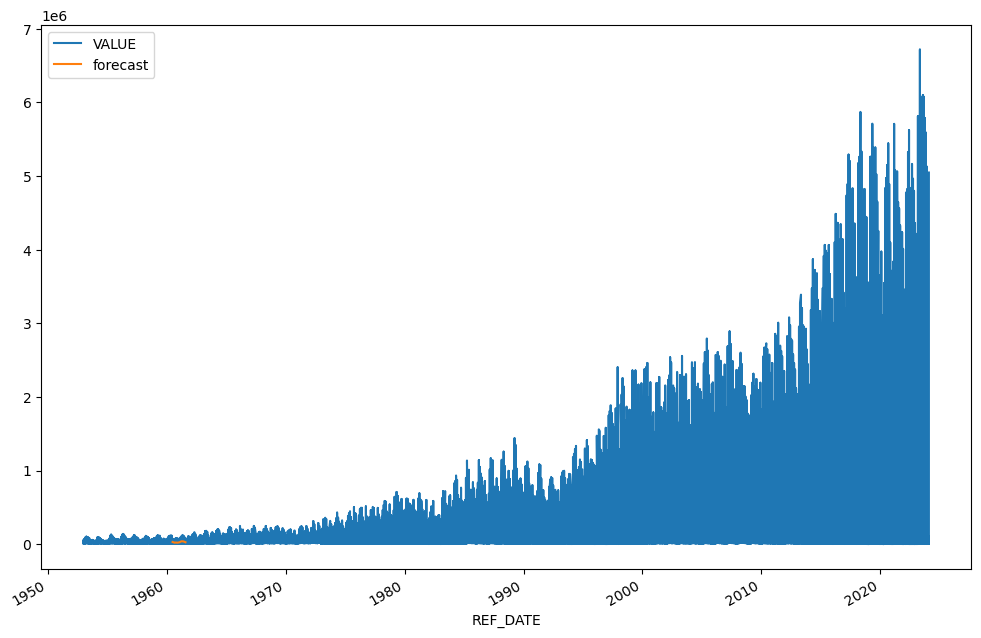

In [97]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['VALUE'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['VALUE','forecast']].plot(figsize=(12,8))